In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, accuracy_score, precision_score, recall_score)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

LOAD PREPROCESSED DATA

In [4]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [5]:
# For autoencoder, we train ONLY on normal transactions
X_train_normal = X_train[y_train == 0]
X_train_fraud = X_train[y_train == 1]

In [6]:
print(f"Normal training samples: {X_train_normal.shape[0]}")
print(f"Fraud training samples: {X_train_fraud.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

Normal training samples: 227451
Fraud training samples: 394
Test samples: 56962
Number of features: 30


BUILD AUTOENCODER MODEL

In [7]:
def create_autoencoder(input_dim, encoding_dim=14):
    """
    Creates an autoencoder with:
    - Encoder: compresses input to lower dimension
    - Decoder: reconstructs original input
    - Bottleneck: learns compressed representation
    """
    
    # Input layer
    input_layer = Input(shape=(input_dim,))
    
    # Encoder
    encoded = Dense(24, activation='relu')(input_layer)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(20, activation='relu')(encoded)
    encoded = Dropout(0.2)(encoded)
    
    # Bottleneck (compressed representation)
    encoded = Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)
    
    # Decoder
    decoded = Dense(20, activation='relu')(encoded)
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(24, activation='relu')(decoded)
    decoded = Dropout(0.2)(decoded)
    
    # Output layer (reconstruction)
    decoded = Dense(input_dim, activation='linear')(decoded)
    
    # Create autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    
    return autoencoder

In [8]:
# Create model
input_dim = X_train.shape[1]
autoencoder = create_autoencoder(input_dim, encoding_dim=14)

In [9]:
# Display model architecture
print("\nAutoencoder Architecture:")
autoencoder.summary()


Autoencoder Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 14)             │           294 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │           504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │           750 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,092 (12.08 KB)

 Trainable params: 3,092 (12.08 KB)

 Non-trainable params: 0 (0.00 B)

COMPILE MODEL

In [10]:
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

SETUP CALLBACKS

In [11]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'autoencoder_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, checkpoint]

TRAIN AUTOENCODER

In [12]:
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9934 - mae: 0.6402
Epoch 1: val_loss improved from None to 0.64892, saving model to autoencoder_best_model.h5


711/711 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.9113 - mae: 0.6165 - val_loss: 0.6489 - val_mae: 0.5287
Epoch 2/50
706/711 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7369 - mae: 0.5623
Epoch 2: val_loss improved from 0.64892 to 0.55223, saving model to autoencoder_best_model.h5


711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7139 - mae: 0.5550 - val_loss: 0.5522 - val_mae: 0.4970
Epoch 3/50
707/711 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6736 - mae: 0.5430
Epoch 3: val_loss improved from 0.55223 to 0.51946, saving model to autoencoder_best_model.h5


711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.6637 - mae: 0.5399 - val_loss: 0.5195 - val_mae: 0.4839
Epoch 4/50
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6441 - mae: 0.5342
Epoch 4: val_loss improved from 0.51946 to 0.50463, saving model to autoencoder_best_model.h5


711/711 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.6402 - mae: 0.5323 - val_loss: 0.5046 - val_mae: 0.4781
Epoch 5/50
706/711 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6318 - mae: 0.5292
Epoch 5: val_loss improved from 0.50463 to 0.49893, saving model to autoencoder_best_model.h5


711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.6325 - mae: 0.5281 - val_loss: 0.4989 - val_mae: 0.4760
Epoch 6/50
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6224 - mae: 0.5255
Epoch 6: val_loss improved from 0.49893 to 0.49544, saving model to autoencoder_best_model.h5


711/711 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.6239 - mae: 0.5247 - val_loss: 0.4954 - val_mae: 0.4735
Epoch 7/50
709/711 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6216 - mae: 0.5235
Epoch 7: val_loss improved from 0.49544 to 0.48746, saving model to autoencoder_best_model.h5


711/711 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.6171 - mae: 0.5222 - val_loss: 0.4875 - val_mae: 0.4714
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6075 - mae: 0.5204
Epoch 8: val_loss improved from 0.48746 to 0.47736, saving model to autoencoder_best_model.h5


711/711 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.6035 - mae: 0.5194 - val_loss: 0.4774 - val_mae: 0.4698
Epoch 9/50
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6022 - mae: 0.5185
Epoch 9: val_loss did not improve from 0.47736
711/711 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.6044 - mae: 0.5179 - val_loss: 0.4789 - val_mae: 0.4685
Epoch 10/50
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6014 - mae: 0.5177
Epoch 10: val_loss improved from 0.47736 to 0.46906, saving model to autoencoder_best_model.h5


711/711 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 0.5992 - mae: 0.5169 - val_loss: 0.4691 - val_mae: 0.4664
Epoch 11/50
709/711 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6013 - mae: 0.5168
Epoch 11: val_loss improved from 0.46906 to 0.46605, saving model to autoencoder_best_model.h5


711/711 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.5977 - mae: 0.5159 - val_loss: 0.4661 - val_mae: 0.4647
Epoch 12/50
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5960 - mae: 0.5152
Epoch 12: val_loss improved from 0.46605 to 0.46394, saving model to autoencoder_best_model.h5


711/711 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.5915 - mae: 0.5145 - val_loss: 0.4639 - val_mae: 0.4645
Epoch 13/50
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5913 - mae: 0.5138
Epoch 13: val_loss improved from 0.46394 to 0.46018, saving model to autoencoder_best_model.h5


711/711 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.5882 - mae: 0.5134 - val_loss: 0.4602 - val_mae: 0.4632
Epoch 14/50
707/711 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5919 - mae: 0.5132
Epoch 14: val_loss improved from 0.46018 to 0.45948, saving model to autoencoder_best_model.h5


711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.5920 - mae: 0.5126 - val_loss: 0.4595 - val_mae: 0.4629
Epoch 15/50
709/711 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5852 - mae: 0.5124
Epoch 15: val_loss did not improve from 0.45948
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.5856 - mae: 0.5124 - val_loss: 0.4599 - val_mae: 0.4634
Epoch 16/50
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5854 - mae: 0.5124
Epoch 16: val_loss improved from 0.45948 to 0.45720, saving model to autoencoder_best_model.h5


711/711 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.5827 - mae: 0.5118 - val_loss: 0.4572 - val_mae: 0.4629
Epoch 17/50
708/711 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5841 - mae: 0.5116
Epoch 17: val_loss improved from 0.45720 to 0.45543, saving model to autoencoder_best_model.h5


711/711 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.5850 - mae: 0.5116 - val_loss: 0.4554 - val_mae: 0.4617
Epoch 18/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5823 - mae: 0.5116
Epoch 18: val_loss did not improve from 0.45543
711/711 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.5825 - mae: 0.5111 - val_loss: 0.4634 - val_mae: 0.4646
Epoch 19/50
705/711 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5853 - mae: 0.5115
Epoch 19: val_loss did not improve from 0.45543
711/711 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.5865 - mae: 0.5113 - val_loss: 0.4653 - val_mae: 0.4626
Epoch 20/50
709/711 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5839 - mae: 0.5114
Epoch 20: val_loss did not improve from 0.45543
711/711 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 0.5791 - mae: 0.5106 - val_loss: 0.4696 - val_mae: 0.4643
Epoch 21/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5808 - mae: 0.5106
Epoch 21: val_loss did not improve from 0.45543
711/711 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/st

711/711 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - loss: 0.5771 - mae: 0.5091 - val_loss: 0.4553 - val_mae: 0.4621
Epoch 25/50
707/711 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5751 - mae: 0.5087
Epoch 25: val_loss improved from 0.45526 to 0.44937, saving model to autoencoder_best_model.h5


711/711 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - loss: 0.5740 - mae: 0.5086 - val_loss: 0.4494 - val_mae: 0.4598
Epoch 26/50
708/711 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5765 - mae: 0.5092
Epoch 26: val_loss did not improve from 0.44937
711/711 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - loss: 0.5760 - mae: 0.5091 - val_loss: 0.4640 - val_mae: 0.4634
Epoch 27/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5795 - mae: 0.5091
Epoch 27: val_loss did not improve from 0.44937
711/711 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - loss: 0.5762 - mae: 0.5083 - val_loss: 0.4495 - val_mae: 0.4602
Epoch 28/50
708/711 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5779 - mae: 0.5084
Epoch 28: val_loss did not improve from 0.44937
711/711 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step - loss: 0.5772 - mae: 0.5081 - val_loss: 0.4592 - val_mae: 0.4630
Epoch 29/50
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5737 - mae: 0.5080
Epoch 29: val_loss did not improve from 0.44937
711/711 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/st

PLOT TRAINING HISTORY

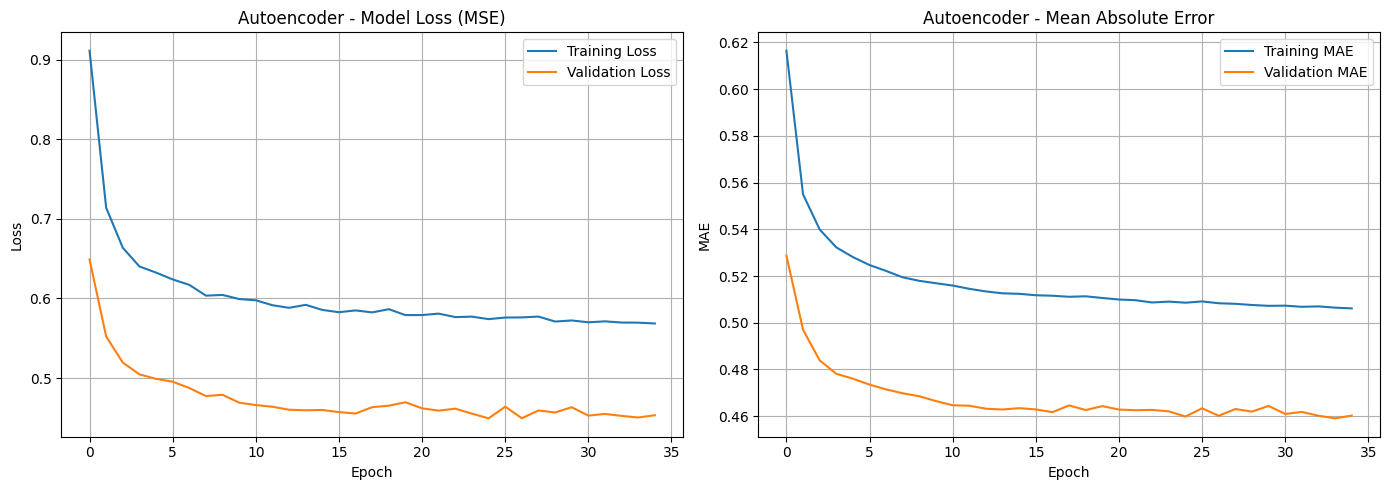

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Autoencoder - Model Loss (MSE)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE')
axes[1].plot(history.history['val_mae'], label='Validation MAE')
axes[1].set_title('Autoencoder - Mean Absolute Error')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('autoencoder_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

CALCULATE RECONSTRUCTION ERRORS

In [14]:
# Get reconstructions
X_train_normal_pred = autoencoder.predict(X_train_normal, verbose=0)
X_train_fraud_pred = autoencoder.predict(X_train_fraud, verbose=0)
X_test_pred = autoencoder.predict(X_test, verbose=0)

# Calculate reconstruction errors (MSE)
train_normal_errors = np.mean(np.square(X_train_normal - X_train_normal_pred), axis=1)
train_fraud_errors = np.mean(np.square(X_train_fraud - X_train_fraud_pred), axis=1)
test_errors = np.mean(np.square(X_test - X_test_pred), axis=1)

print(f"\nNormal transactions - Mean reconstruction error: {train_normal_errors.mean():.6f}")
print(f"Fraud transactions - Mean reconstruction error: {train_fraud_errors.mean():.6f}")



Normal transactions - Mean reconstruction error: 0.451137
Fraud transactions - Mean reconstruction error: 20.038351


VISUALIZE RECONSTRUCTION ERRORS

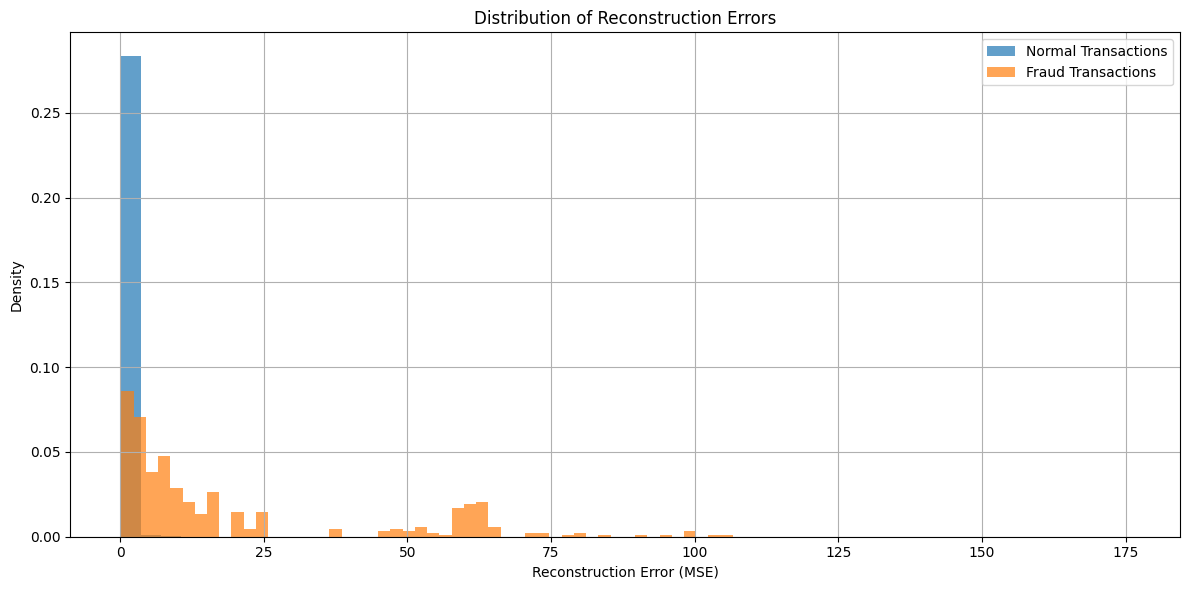

In [15]:
plt.figure(figsize=(12, 6))

plt.hist(train_normal_errors, bins=50, alpha=0.7, label='Normal Transactions', density=True)
plt.hist(train_fraud_errors, bins=50, alpha=0.7, label='Fraud Transactions', density=True)
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Density')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('autoencoder_reconstruction_errors.png', dpi=300, bbox_inches='tight')
plt.show()

FIND OPTIMAL THRESHOLD

In [16]:
# Try different thresholds
thresholds = np.percentile(train_normal_errors, np.arange(90, 100, 0.5))
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    y_pred = (test_errors > threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nOptimal threshold: {best_threshold:.6f}")
print(f"Best F1-Score: {best_f1:.4f}")


Optimal threshold: 3.479933
Best F1-Score: 0.3448


In [17]:
# Use optimal threshold for predictions
y_pred = (test_errors > best_threshold).astype(int)
y_pred_prob = test_errors  # Use reconstruction error as confidence score

EVALUATE MODEL

In [18]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, test_errors)

print(f"\nTest Set Performance:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {auc:.4f}")


Test Set Performance:
Accuracy:  0.9947
Precision: 0.2186
Recall:    0.8163
F1-Score:  0.3448
ROC-AUC:   0.9581


In [19]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00     56864
       Fraud       0.22      0.82      0.34        98

    accuracy                           0.99     56962
   macro avg       0.61      0.91      0.67     56962
weighted avg       1.00      0.99      1.00     56962



CONFUSION MATRIX

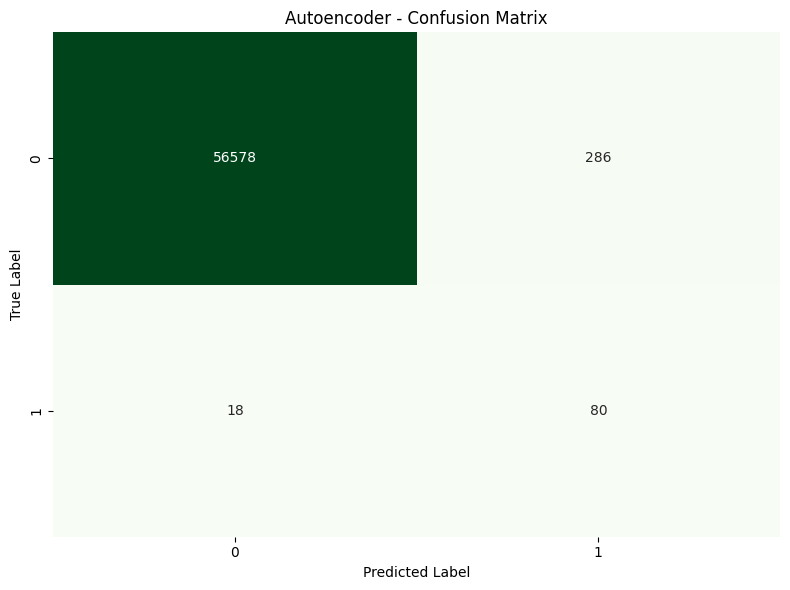

In [20]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Autoencoder - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('autoencoder_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

ROC CURVE

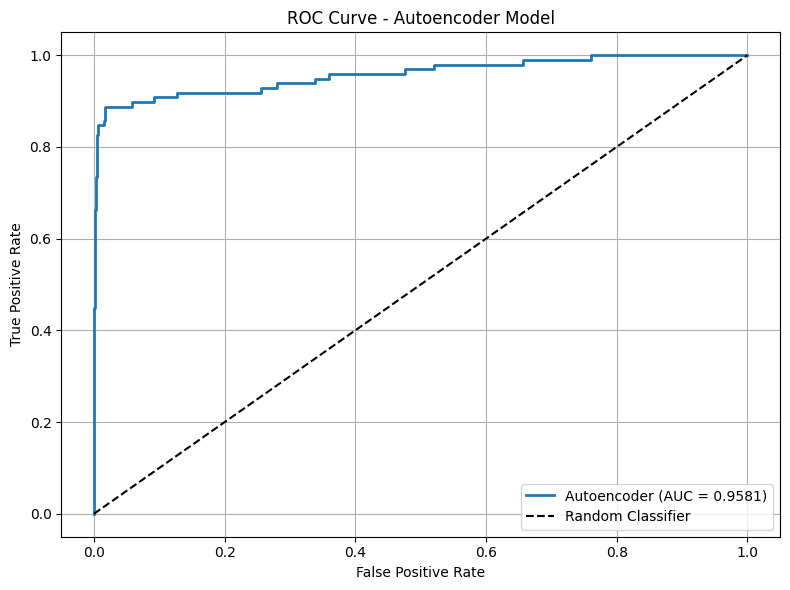

In [21]:
fpr, tpr, _ = roc_curve(y_test, test_errors)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Autoencoder (AUC = {auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Autoencoder Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('autoencoder_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

PRECISION-RECALL CURVE

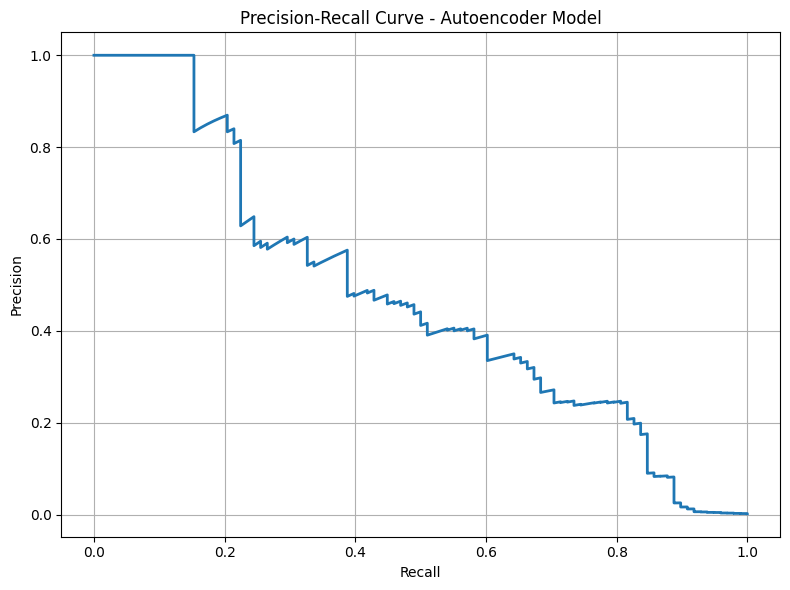

In [22]:
precision_vals, recall_vals, _ = precision_recall_curve(y_test, test_errors)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Autoencoder Model')
plt.grid(True)
plt.tight_layout()
plt.savefig('autoencoder_precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

VISUALIZE LATENT SPACE

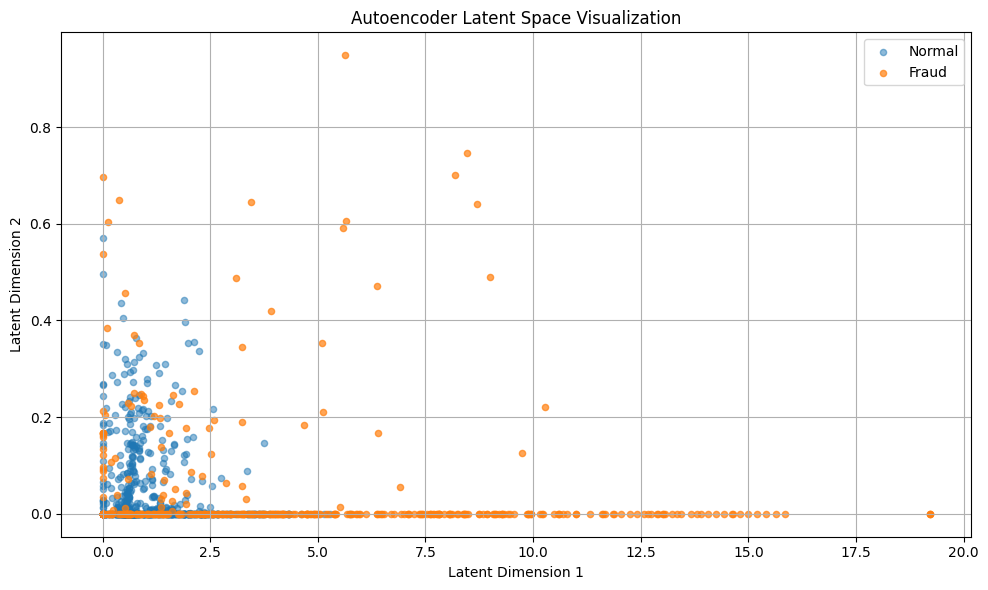

In [25]:
# Create encoder model
encoder = Model(inputs=autoencoder.input, 
                outputs=autoencoder.get_layer('bottleneck').output)

# Get encoded representations
encoded_normal = encoder.predict(X_train_normal[:1000], verbose=0)
encoded_fraud = encoder.predict(X_train_fraud, verbose=0)

# Visualize first 2 dimensions
plt.figure(figsize=(10, 6))
plt.scatter(encoded_normal[:, 0], encoded_normal[:, 1], 
           alpha=0.5, label='Normal', s=20)
plt.scatter(encoded_fraud[:, 0], encoded_fraud[:, 1], 
           alpha=0.7, label='Fraud', s=20)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Autoencoder Latent Space Visualization')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('autoencoder_latent_space.png', dpi=300, bbox_inches='tight')
plt.show()

SAVE RESULTS

In [26]:
results = {
    'Model': 'Autoencoder',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'ROC-AUC': auc,
    'Threshold': best_threshold
}

results_df = pd.DataFrame([results])
results_df.to_csv('autoencoder_results.csv', index=False)